# Model
## Imports

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
import tensorflow as tf

# Images
from PIL import Image
from matplotlib import image
from IPython.display import display

# Model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import SGD, Adam

## Utility functions

In [2]:
def plot_face_center(x, coordinates):
    """Plot face with marked center.
    
    Where x is numpy array reprezenting single picture
    """
    fig, ax = plt.subplots(sharex=True,sharey=True)
    ax.imshow(x[:,:,:].astype('uint8'))
    ax.scatter(coordinates[0], coordinates[1], marker='X', c='r', s=10)


def plot_faces(X, Y, rows_number=5, columns_number=5):
    """Plot rows_number * columns_number faces with marked center.
    
    Faces are choosen randomly.
    """
    n = 0
    irand=np.random.choice(Y.shape[0],rows_number*columns_number)
    fig, ax = plt.subplots(rows_number,columns_number,sharex=True,sharey=True,figsize=[rows_number*2,columns_number*2])
    for row in range(rows_number):
        for col in range(columns_number):
            ax[row,col].imshow(X[irand[n],:,:,:].astype('uint8'))
            ax[row,col].scatter(Y[irand[n],0], Y[irand[n],1], marker='X',c='r',s=10)
            ax[row,col].set_xticks(())
            ax[row,col].set_yticks(())
            ax[row,col].set_title('image index = %d' %(irand[n]),fontsize=10)
            n += 1


def plot_prediction(x, y_pred):
    """Plot single face with marked predicted centre.
    
    Where x is numpy array reprezenting a picture
    """
    fig, ax = plt.subplots(sharex=True,sharey=True)
    ax.imshow(x[:,:,:].astype('uint8'))
    ax.scatter(y_pred[0], y_pred[1], marker='X', c='b', s=10)


def plot_predictions(X, Y, Y_pred, rows_number=5, columns_number=5):
    """Plot faces with marked labeled and predicted centre.
    
    Where X is numpy array reprezenting a pictures
    """
    n = 0
    irand=np.random.choice(Y.shape[0],rows_number*columns_number)
    fig, ax = plt.subplots(rows_number,columns_number,sharex=True,sharey=True,figsize=[rows_number*2,columns_number*2])
    for row in range(rows_number):
        for col in range(columns_number):
            ax[row,col].imshow(X[irand[n],:,:,:].astype('uint8'))
            ax[row,col].scatter(Y[irand[n],0], Y[irand[n],1], marker='X',c='r',s=10)
            ax[row,col].scatter(Y_pred[irand[n],0], Y_pred[irand[n],1], marker='X',c='b',s=10)
            ax[row,col].set_xticks(())
            ax[row,col].set_yticks(())
            ax[row,col].set_title('image index = %d' %(irand[n]),fontsize=10)
            n += 1


def plot_curve(epochs, hist, list_of_metrics):
    """Plot a curve of  metrics vs. epoch
    
    Arguments:
    epochs -- epochs list
    hist -- training history given as pd.DataFrame
    list_of_metics -- list of metrics to plot
    """    
    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Value")

    # Plot given metrics
    for m in list_of_metrics:
        x = hist[m]
        plt.plot(epochs[1:], x[1:], label=m)

    plt.legend()

## Load data

In [107]:
data_path = os.path.join(os.getcwd(), "data")
print(os.listdir(data_path))
# For small data
# X = np.load(os.path.join(data_path, 'X_small.npy'))
# Y = np.load(os.path.join(data_path, 'Y_small.npy'))
X = np.load(os.path.join(data_path, 'X_FK.npy'))
Y = np.load(os.path.join(data_path, 'Y_FK.npy'))

['Face Images with Marked Landmark Point', 'Facial Keypoints', 'X_FK.npy', 'X_small.npy', 'Y_FK.npy', 'Y_small.npy']


## Quick glance at data:

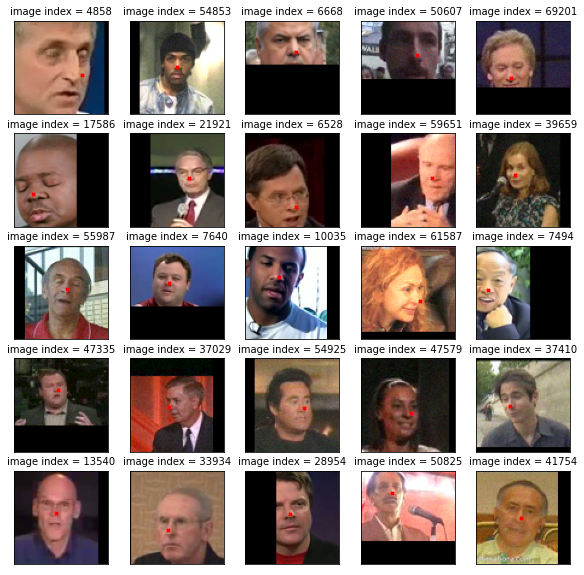

In [108]:
plot_faces(X, Y)

In [5]:
print(X.shape)
print(Y.shape)

(70900, 78, 78, 3)
(70900, 2)


## Normalize data and scale target

In [6]:
# Make sure that X, Y are in range [0, 1]
picture_size = X[0, :].shape[0]
X = X / 255.0
Y = Y / picture_size

In [9]:
print(X.max(), X.min(), X.mean())
print(Y.max(), Y.min(), Y.mean())

1.0 0.0 0.3126183156028107
0.978125 0.018880208333333332 0.48194869218183367


## Split data into training, validation and test sets

In [7]:
# test set size
test_size = 2000
# Cross Validation set size
val_size = 6000
# val_size = 200
random_seed=21
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size / X.shape[0], random_state=random_seed)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=val_size / X_train.shape[0], random_state=random_seed)

In [7]:
print(X_train.shape, Y_train.shape)
print(X_val.shape, Y_val.shape)
print(X_test.shape, Y_test.shape)

(62900, 78, 78, 3) (62900, 2)
(6000, 78, 78, 3) (6000, 2)
(2000, 78, 78, 3) (2000, 2)


## Model with architecture following [paper ](http://mmlab.ie.cuhk.edu.hk/archive/CNN_FacePoint.htm)
### Build model

In [29]:
# In orginal model authors used 3 disjointed networks one for each RGB value.
# We will use joined version
multiply_sizes=3
model = Sequential()
model.add(MaxPool2D(pool_size=(2, 2), input_shape=(picture_size, picture_size, 3)))
model.add(Conv2D(kernel_size=(4, 4), activation='relu', filters=20 * multiply_sizes))
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(kernel_size=(3, 3), activation='relu', filters=40 * multiply_sizes))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(kernel_size=(3, 3), activation='relu', filters=60 * multiply_sizes))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(kernel_size=(2, 2), activation='relu', filters=80 * multiply_sizes))
model.add(Flatten())
model.add(Dense(120, activation='relu'))
model.add(Dense(2, activation='sigmoid'))

model.output_shape

(None, 2)

In [63]:
# Model with regularization
r_rate = 0.000001
dr_rate = 0.5
# In orginal model authors used 3 disjointed networks one for each RGB value.
# We will use joined version
multiply_sizes = 3
regu = tf.keras.regularizers.l2(r_rate)
model = Sequential()
model.add(MaxPool2D(pool_size=(2, 2), input_shape=(picture_size, picture_size, 3)))
model.add(Conv2D(kernel_size=(4, 4), activation='relu', filters=20 * multiply_sizes, kernel_regularizer=regu))
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(dr_rate))
model.add(Conv2D(kernel_size=(3, 3), activation='relu', filters=40 * multiply_sizes, kernel_regularizer=regu))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(dr_rate))
model.add(Conv2D(kernel_size=(3, 3), activation='relu', filters=60 * multiply_sizes, kernel_regularizer=regu))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(dr_rate))
model.add(Conv2D(kernel_size=(2, 2), activation='relu', filters=80 * multiply_sizes, kernel_regularizer=regu))
model.add(Flatten())
model.add(Dense(120, activation='relu'))
model.add(Dense(2, activation='sigmoid'))

### Compile model

In [64]:
lr=1e-4
opt = Adam(learning_rate=lr)
model.compile(loss='mean_squared_error', optimizer=opt)

### Train model

In [65]:
# Use mini batch gradient descent
# batch size should fit in GPU memory
b_size = 64
history = model.fit(X_train, Y_train, batch_size=b_size, epochs=20, validation_data = (X_val, Y_val))

Epoch 1/20
983/983 [==============================] - 179s 182ms/step - loss: 0.0138 - val_loss: 0.0107
Epoch 2/20
983/983 [==============================] - 171s 174ms/step - loss: 0.0088 - val_loss: 0.0068
Epoch 3/20
983/983 [==============================] - 167s 170ms/step - loss: 0.0068 - val_loss: 0.0058
Epoch 4/20
983/983 [==============================] - 165s 168ms/step - loss: 0.0058 - val_loss: 0.0046
Epoch 5/20
983/983 [==============================] - 165s 168ms/step - loss: 0.0052 - val_loss: 0.0040
Epoch 6/20
983/983 [==============================] - 164s 167ms/step - loss: 0.0046 - val_loss: 0.0034
Epoch 7/20
983/983 [==============================] - 166s 169ms/step - loss: 0.0041 - val_loss: 0.0030
Epoch 8/20
983/983 [==============================] - 167s 170ms/step - loss: 0.0038 - val_loss: 0.0027
Epoch 9/20
983/983 [==============================] - 165s 168ms/step - loss: 0.0035 - val_loss: 0.0025
Epoch 10/20
983/983 [==============================] - 165s 168m

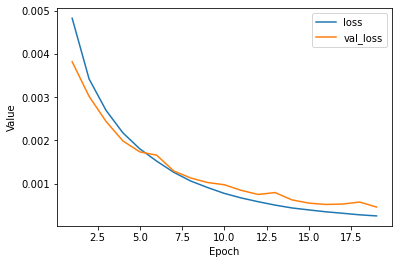

In [32]:
epochs = history.epoch
hist = pd.DataFrame(history.history)
metrics = ['loss', 'val_loss']
plot_curve(epochs, hist, metrics)

In [97]:
# Additional training with smaller learning rate
lr=1e-5
opt = Adam(learning_rate=lr)
model.compile(loss='mean_squared_error', optimizer=opt)
b_size = 64
history = model.fit(X_train, Y_train, batch_size=b_size, epochs=10, validation_data = (X_val, Y_val))

Epoch 1/10
983/983 [==============================] - 157s 160ms/step - loss: 8.7950e-05 - val_loss: 2.7912e-04
Epoch 2/10
983/983 [==============================] - 159s 161ms/step - loss: 8.5829e-05 - val_loss: 2.7746e-04
Epoch 3/10
983/983 [==============================] - 150s 153ms/step - loss: 8.3861e-05 - val_loss: 2.7606e-04
Epoch 4/10
983/983 [==============================] - 146s 149ms/step - loss: 8.1936e-05 - val_loss: 2.7218e-04
Epoch 5/10
983/983 [==============================] - 145s 148ms/step - loss: 7.9916e-05 - val_loss: 2.6873e-04
Epoch 6/10
983/983 [==============================] - 145s 148ms/step - loss: 7.8256e-05 - val_loss: 2.6662e-04
Epoch 7/10
983/983 [==============================] - 145s 148ms/step - loss: 7.6298e-05 - val_loss: 2.6667e-04
Epoch 8/10
983/983 [==============================] - 145s 148ms/step - loss: 7.4908e-05 - val_loss: 2.6457e-04
Epoch 9/10
983/983 [==============================] - 145s 148ms/step - loss: 7.3293e-05 - val_loss: 2.5

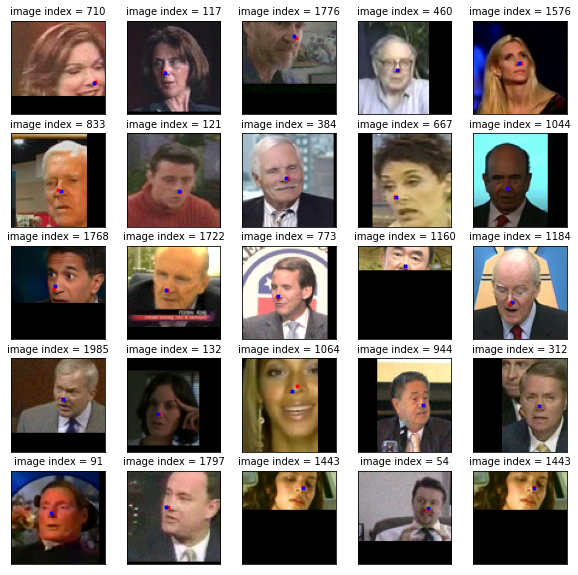

In [99]:
Y_test_pred = model.predict(X_test)
plot_predictions(X_test * 255.0, Y_test * picture_size, Y_test_pred * picture_size)

## Evaluate model

In [100]:
model.evaluate(X_test, Y_test)

63/63 [==============================] - 1s 17ms/step - loss: 2.4435e-04


0.0002443483972456306

## Test model

In [16]:
def resize_picture(img_array, new_size=78):
    """Resize picture into given size
    
    returns trasformed picture and scale used during transformation
    """
    img = Image.fromarray(img_array)
    # resize image
    orginal_size = img.size
    img.thumbnail((new_size, new_size))
    # scale
    scale_x = img.size[0] / orginal_size[0]
    scale_y = img.size[1] / orginal_size[1]
    image_arr = np.asarray(img)
    # Add padding
    data = np.zeros((new_size, new_size, 3))
    data[:image_arr.shape[0], :image_arr.shape[1], :] = image_arr
    return data, scale_x, scale_y


def preprocess_picture(file_name, new_size=78):
    """Transform given picture into new_size * new_size array
    
    returns trasformed picture and scale used during transformation
    """
    img = Image.open(file_name)
    # Covert into RGB
    if img.mode=='RGBA':
        background = Image.new("RGB", img.size, (255, 255, 255))
        background.paste(img, mask=img.split()[3])
        img = background
    return resize_picture(np.asarray(img), new_size)


def test_model(file_name, model):
    """Test model on single picture
    
    Plot face with predicted point
    """
    x, scale_x, scale_y = preprocess_picture(file_name)
    x = x / 255.0
    x = np.expand_dims(x, axis=0)
    y_pred = model.predict(x)
    x, y_pred = x * 255.0, y_pred * picture_size
    # load orginal image
    img = Image.open(file_name)
    # Covert into RGB
    if img.mode=='RGBA':
        background = Image.new("RGB", img.size, (255, 255, 255))
        background.paste(img, mask=img.split()[3])
        img = background
    img_arr = np.asarray(img)
    # Re scale
    y_pred[0, 0] = y_pred[0, 0] / scale_x
    y_pred[0, 1] = y_pred[0, 1] / scale_y
    plot_prediction(img_arr, y_pred[0, :])

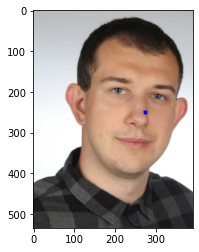

In [109]:
test_model(os.path.join("pictures", "test1.png"), model)

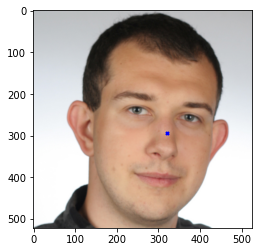

In [110]:
test_model(os.path.join("pictures", "test2.png"), model)

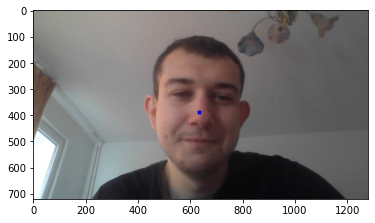

In [111]:
test_model(os.path.join("pictures", "test4.jpg"), model)

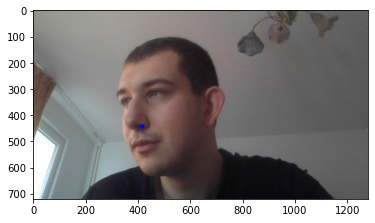

In [112]:
test_model(os.path.join("pictures", "test5.jpg"), model)

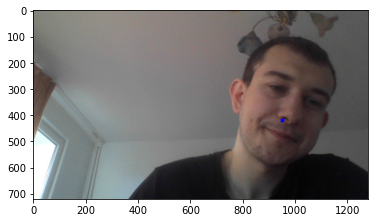

In [113]:
test_model(os.path.join("pictures", "test6.jpg"), model)

## Transfer learning model
### Load model

In [87]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input

In [88]:
TL_model = ResNet50(include_top=False, input_shape=(78, 78, 3), weights="imagenet")

In [89]:
TL_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 78, 78, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 84, 84, 3)    0           input_8[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 39, 39, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 39, 39, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [47]:
TL_model.output_shape

(None, 3, 3, 2048)

### Freeze weights

In [90]:
for layer in TL_model.layers:
    if layer.name not in ['conv5_block3_out', 'conv5_block3_add', 'conv5_block3_3_bn', 'conv5_block3_3_conv']:
        layer.trainable = False

### Add head to pretrained model

In [91]:
head = Sequential()
head.add(TL_model)
head.add(Flatten())
head.add(Dense(240, activation='relu'))
head.add(Dense(120, activation='relu'))
head.add(Dense(2, activation='sigmoid'))
TL_model = head
TL_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 3, 3, 2048)        23587712  
_________________________________________________________________
flatten_4 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_11 (Dense)             (None, 240)               4423920   
_________________________________________________________________
dense_12 (Dense)             (None, 120)               28920     
_________________________________________________________________
dense_13 (Dense)             (None, 2)                 242       
Total params: 28,040,794
Trainable params: 5,507,802
Non-trainable params: 22,532,992
_________________________________________________________________


### Prepare data

In [ ]:
# Rescale input
X_train = X_train * 255.0
X_val = X_val * 255.0

In [64]:
TL_X_train = X_train.copy()
TL_X_val = X_val.copy()

In [65]:
for i in range(TL_X_train.shape[0]):
    TL_X_train[i, :] = preprocess_input(TL_X_train[i, :])
for i in range(TL_X_val.shape[0]):
    TL_X_val[i, :] = preprocess_input(TL_X_val[i, :])

### Compile model

In [49]:
lr=1e-4
opt = Adam(learning_rate=lr)
TL_model.compile(loss='mean_squared_error', optimizer=opt)

NameError: name 'TL_model' is not defined

### Train model

In [93]:
b_size = 64
history = TL_model.fit(TL_X_train, Y_train, batch_size=b_size, epochs=10, validation_data = (TL_X_val, Y_val))

Epoch 1/10
983/983 [==============================] - 717s 729ms/step - loss: 0.0063 - val_loss: 0.0040
Epoch 2/10
983/983 [==============================] - 708s 721ms/step - loss: 0.0024 - val_loss: 0.0028
Epoch 3/10
983/983 [==============================] - 710s 722ms/step - loss: 0.0015 - val_loss: 0.0023
Epoch 4/10
983/983 [==============================] - 710s 722ms/step - loss: 0.0010 - val_loss: 0.0019
Epoch 5/10
983/983 [==============================] - 720s 732ms/step - loss: 8.1918e-04 - val_loss: 0.0018
Epoch 6/10
983/983 [==============================] - 715s 727ms/step - loss: 7.1248e-04 - val_loss: 0.0017
Epoch 7/10
983/983 [==============================] - 808s 822ms/step - loss: 6.0004e-04 - val_loss: 0.0016
Epoch 8/10
983/983 [==============================] - 813s 827ms/step - loss: 5.1300e-04 - val_loss: 0.0014
Epoch 9/10
983/983 [==============================] - 822s 836ms/step - loss: 4.4190e-04 - val_loss: 0.0014
Epoch 10/10
983/983 [=======================

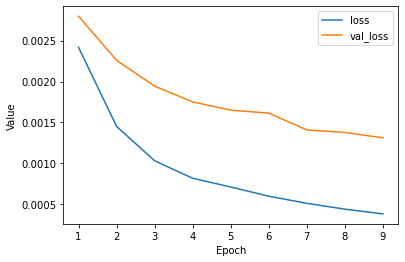

In [94]:
epochs = history.epoch
hist = pd.DataFrame(history.history)
metrics = ['loss', 'val_loss']
plot_curve(epochs, hist, metrics)

In [95]:
def test_tl_model(file_name, model):
    """Test transfer learning model on single picture
    
    Plot face with predicted point
    """
    x, scale_x, scale_y = preprocess_picture(file_name)
    x = preprocess_input(x)
    x = np.expand_dims(x, axis=0)
    y_pred = model.predict(x)
    x, y_pred = x * 255.0, y_pred * picture_size
    # load orginal image
    img = Image.open(file_name)
    # Covert into RGB
    if img.mode=='RGBA':
        background = Image.new("RGB", img.size, (255, 255, 255))
        background.paste(img, mask=img.split()[3])
        img = background
    img_arr = np.asarray(img)
    # Re scale
    y_pred[0, 0] = y_pred[0, 0] / scale_x
    y_pred[0, 1] = y_pred[0, 1] / scale_y
    plot_prediction(img_arr, y_pred[0, :])

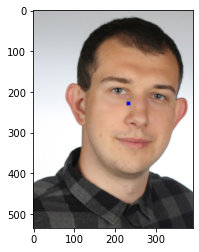

In [97]:
test_tl_model(os.path.join("pictures", "test1.png"), model)

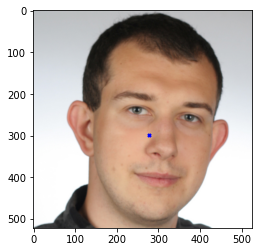

In [98]:
test_tl_model(os.path.join("pictures", "test2.png"), model)

## Save model

In [106]:
# Save model
# model.save(os.path.join(os.getcwd(), 'models', 'basic_model'))
# Save model with regularization
# model.save(os.path.join(os.getcwd(), 'models', 'reg_model'))

INFO:tensorflow:Assets written to: C:\Users\ciche\OneDrive\Pulpit\solvro\Face-Center-Detection\models\basic_model\assets
